In [12]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from scipy.sparse import coo_matrix, hstack

In [2]:
df_full = pd.read_csv('data/df_quotes_clean.csv', dtype={'label':str})
df_full.head()

,label,quote,context,author_id,author_name,date,categories,staff,label_binary,context_clean,...,affiliation_other,affiliation_republican,affiliation_state official,affiliation_talk show host,gender_andy,gender_female,gender_male,gender_mostly_female,gender_mostly_male,gender_unknown
0,0,pennsylvania banned alcohol sale,a Facebook post,viral-image,Viral image,"November 24, 2020","Facebook Fact-checks, Coronavirus",Ciara O'Rourke,0,facebook,...,0,0,0,0,0,0,0,0,0,1
1,0,666000 teacher laid already since march,a virtual roundtable,joe-biden,Joe Biden,"November 18, 2020","Education, Coronavirus",Bill McCarthy,0,roundtable,...,0,0,0,0,0,0,1,0,0,0
2,0,david perdue say hell everything power make su...,an ad,jon-ossoff,Jon Ossoff,"November 17, 2020","Georgia, Negative Campaigning",Tom Kertscher,0,ad,...,0,0,0,0,0,0,1,0,0,0
3,0,say 47 additional county used software caused ...,a Facebook post,ted-nugent,Ted Nugent,"November 17, 2020","Elections, Facebook Fact-checks",Samantha Putterman,0,facebook,...,0,1,0,0,0,0,1,0,0,0
4,0,voter fraud exposed georgia 2600 vote found,in a Live video,facebook-posts,Facebook posts,"November 16, 2020","Georgia, Elections, Facebook Fact-checks",Daniel Funke,0,video,...,0,0,0,0,0,0,0,0,0,1


## Define the Features that will be Included in Modeling

In [3]:
text_features = ['num_words', 'num_chars', 'avg_word_len', 'num_stopwords']
date_features = [col for col in df_full.columns if ('date_' in col) and (col not in ['date_formatted'])]
author_features = [col for col in df_full.columns if ('author_' in col) and (col not in ['author_id', 'author_name'])]
context_features = [col for col in df_full.columns if ('context_' in col) and (col != 'context_clean')]
gender_features = [col for col in df_full.columns if 'gender_' in col]
affiliation_features = [col for col in df_full.columns if 'affiliation_' in col]
features_cols = ['quote'] + context_features + affiliation_features + gender_features + author_features
#features_cols = ['quote'] # To test with only quote

In [4]:
features = df_full[features_cols]
#labels = df_full['label'].to_numpy()
labels = df_full['label_binary'].to_numpy()

## Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)

## TF-IDF Vectorization

In [6]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.7)
tfidf_vect.fit(X_train['quote'].to_numpy())
X_train_quote =  tfidf_vect.transform(X_train['quote'].to_numpy())
X_test_quote =  tfidf_vect.transform(X_test['quote'].to_numpy())

X_train_quote.shape

(12534, 13283)

## Concatenate Quote and Features Sparse Matrices 

In [7]:
selected_features = [feat for feat in features if feat not in ['quote']]
X_train_full = hstack([coo_matrix(X_train_quote), coo_matrix(X_train[selected_features])])
X_test_full = hstack([coo_matrix(X_test_quote), coo_matrix(X_test[selected_features])])

In [8]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_full, y_train)
prediction = knn.predict(X_test_full)
accuracy = (prediction == y_test).mean()
print(f'Prediction accuracy {accuracy}')

Prediction accuracy 0.6824274013402829


In [9]:
def CrossValidate(clf, splits, X_train, y_train):
    scores = cross_val_score(clf, X_train, y_train, cv=splits)
    print('Cross-validated scores:', scores)
    print(f'Mean Accuracy: {scores.mean():0.2f} (+/- {scores.std() * 2:0.2f})')

In [10]:
clf = KNeighborsClassifier(n_neighbors=5)
CrossValidate(clf, 5, X_train_full, y_train)

Cross-validated scores: [0.66852812 0.69525329 0.67291584 0.67889908 0.68475658]
Mean Accuracy: 0.68 (+/- 0.02)


In [22]:
clf = MultinomialNB()
CrossValidate(clf, 5, X_train_full, y_train)

Cross-validated scores: [0.69684882 0.70522537 0.70801755 0.70602314 0.71029529]
Mean Accuracy: 0.71 (+/- 0.01)


In [23]:
clf = SVC()
CrossValidate(clf, 5, X_train_full, y_train)

Cross-validated scores: [0.70283207 0.70243319 0.70243319 0.70243319 0.70271349]
Mean Accuracy: 0.70 (+/- 0.00)


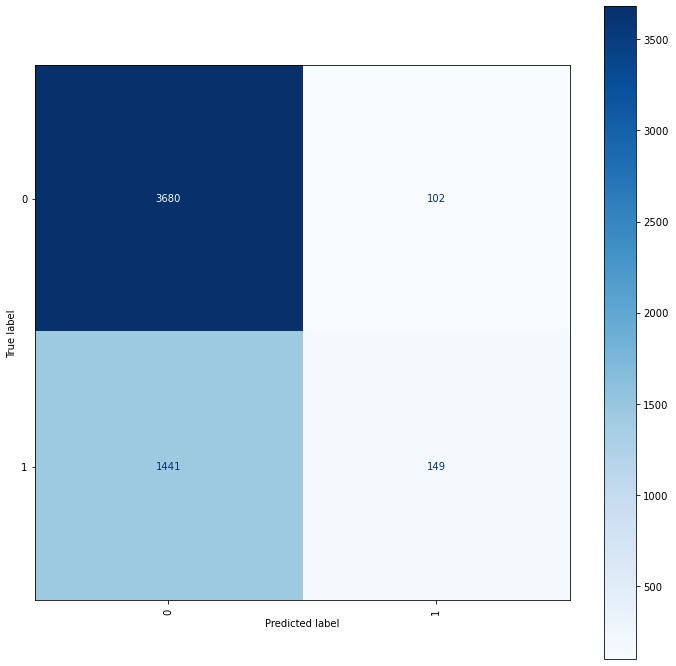

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))
disp = metrics.plot_confusion_matrix(MultinomialNB().fit(X_train_full, y_train), 
                             X_test_full, y_test,
                             display_labels=np.unique(y_train), 
                             ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')